In [1]:
import pycutestmgr as cute
import time
import pdb 
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, issparse
from ipsolver import equality_constrained_sqp, projections
%matplotlib inline
cute.clearCache('HS71')

# Problems from ``CUTEst`` Problem Collection
## Import Problem

In [2]:
problems = [("HAGER2", {"N": 5000}),  # 1
            ("HAGER3", {"N": 5000}),  # 2
            ("ELEC", {}),  # 3
            ("CHANNEL", {}),  # 4
            ("ORTHREGA", {'LEVELS': 5}),  # 5
            ("ORTHREGC", {'NPTS': 500}),  # 6
            ("ORTHREGD", {'NPTS': 2500}),  # 7 - FAILS TO CONVERGE FOR DEFAULT PARAMETERS!!    
                                           # BUT CONVERGES FOR: *initial_trust_radius=100,
                                           #                    *initial_penalty=1000,
            ("ORTHREGD", {'NPTS': 500}), # 8
            ("ORTHREGD", {'NPTS': 5000}), # 9 - FAILS TO CONVERGE FOR DEFAULT PARAMETERS!! 
                                          # BUT CONVERGES FOR: *initial_trust_radius=100,
                                          #                    *initial_penalty=1000,
            ("DTOC1ND", {'N': 500, 'NX':2, 'NY':4}), # 10 -FAILS TO CONVERGE FOR DEFAULT PARAMETERS!!
                                                     # BUT CONVERGES FOR: *initial_trust_radius=1000,
                                                     #                    *initial_penalty=1,
            ("DTOC2", {'N': 500, 'NX':2, 'NY':4}), # 11
            ("DTOC3", {}), # 12
            ("DTOC4", {'N': 5000}),  # 13
            ("DTOC5", {'N': 5000}),  # 14
            ("DTOC6", {'N': 1001}),  # 15
            ("EIGENA2", {'N': 50}),  # 16
            ("EIGENA2", {'N': 10}),  # 17
            ("EIGENC2", {'M': 25}),  # 18
            ("EIGENC2", {'M': 2}),  # 19
            ("EIGENC2", {'M': 10}),  # 20
            ("ARTIF", {'N': 1000}),  # 21
            ("BRATU3D", {'P':17})]  # 22

number = 3
name = problems[number-1][0]
cute.clearCache(name)
cute.prepareProblem(name, sifParams=problems[number-1][1])
problem = cute.importProblem(name)
info = problem.getinfo()
x0 = info["x"]
print(info["n"], info["m"])
v0 = info["v"]


def hess(x, v):
    return csc_matrix(problem.sphess(x, v))


def fun(x):
    return problem.obj(x)[0]


def grad(x):
    _, g1 = problem.obj(x, True)
    return g1


def constr(x):
    return problem.cons(x)


def jac(x):
    _, A1 = problem.cons(x, True)
    return csc_matrix(A1)

(600, 200)


## Optimize Problem

In [3]:
start_time = time.time()
x, info = equality_constrained_sqp(fun, grad, hess, constr, jac, x0, v0, 
                                   initial_trust_radius=1,
                                   initial_penalty=1,
                                   return_all=True)
total_time = time.time() - start_time

## Display Results

In [4]:
print('f = '+ str(info["fun"]))
print('optimality = ' + str(info["opt"]))
print('c violation = ' + str(info["constr_violation"]))
print('niter = ' + str(info["niter"]))
print('total time = ' + str(total_time))


f = 18439.1273014
optimality = 1.49428018013e-05
c violation = 1.20901831387e-14
niter = 117
total time = 5.76803302765


In [5]:
n = len(info["allvecs"])
func = np.zeros(n)
constr_violation = np.zeros(n)
optimality = np.zeros(n)
for k in range(n):
    xk = info["allvecs"][k]
    vk = info["allmult"][k]
    gk = grad(xk)
    ck = constr(xk)
    Ak = jac(xk)
    func[k] = fun(xk)
    optimality[k] = norm(gk + Ak.T.dot(vk))
    constr_violation[k] = np.linalg.norm(ck)

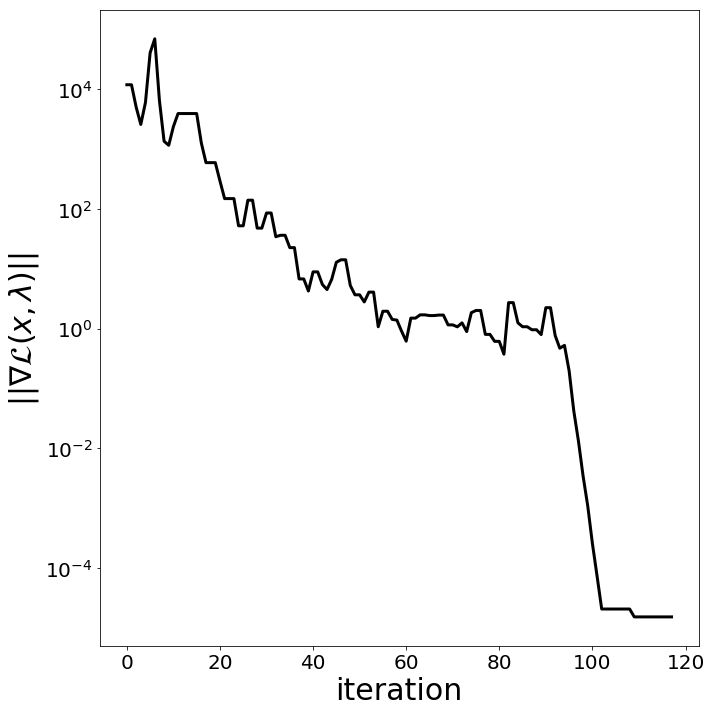

In [6]:
plt.figure(figsize=(10, 10))
plt.semilogy(range(n), optimality, color='black', lw=3)
plt.xlabel("iteration", fontsize=30)
plt.ylabel(r"$\||\nabla \mathcal{L}(x, \lambda)\||$", fontsize=30)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.savefig("optimality_elec_soc.png")